In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhoogla/cictoniot")

print("Path to dataset files:", path)
file_path = path + "/CIC-ToN-IoT-V2.parquet"

100%|██████████| 353M/353M [00:02<00:00, 138MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/cictoniot/versions/2


In [ ]:
import pandas as pd

file_path = path + "/CIC-ToN-IoT-V2.parquet"

# Load only the metadata first
df = pd.read_parquet(file_path, engine="pyarrow")

# Number of rows
print("Total rows:", len(df))
print("Total columns:", df.shape[1])



Total rows: 4847499
Total columns: 79


First 10 rows:
         Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
2050539         6          44399                  5                       2   
2338650         6         633847                  7                       5   
3059126         6          43029                  5                       3   
1159980         6          60250                  4                       5   
1364066         6          41999                  3                       2   
3368370         6            105                  2                       0   
287322         17        3136805                 16                       0   
419392          6            679                  2                       0   
3380199         6         670722                  3                       4   
4224287         6         696236                  5                       5   

         Fwd Packets Length Total  Bwd Packets Length Total  \
2050539                     363.0                   

In [ ]:
# %% ------------------ Imports ------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
# %% ------------------ 1. Load Parquet in chunks ------------------
file_path = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"

df = pd.read_parquet(file_path).sample(4500000, random_state=42)

print("First 10 rows:")
print(df.head(10))

# %% ------------------ 2. Explore Attack and Label columns ------------------
print("\nUnique values in 'Attack' column and counts:")
print(df['Attack'].value_counts())

print("\nUnique values in 'Label' column and counts:")
print(df['Label'].value_counts())

# %% ------------------ 3. Preprocessing ------------------
X = df.drop(columns=['Attack', 'Label'])
y = df['Label'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Incremental PCA (batch processing)
n_components = 50  # reduce to 50 features
ipca = IncrementalPCA(n_components=n_components, batch_size=5000)
X_reduced = ipca.fit_transform(X_scaled)

print("\nShape after Incremental PCA:", X_reduced.shape)

# Reshape for CNN
X_reduced = np.expand_dims(X_reduced, axis=2)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

# %% ------------------ 4. CNN Model ------------------
def create_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Path 1
    x1 = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(64, kernel_size=3, activation='relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)

    # Path 2
    x2 = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x2 = AveragePooling1D(pool_size=2)(x2)
    x2 = Conv1D(64, kernel_size=3, activation='relu')(x2)
    x2 = AveragePooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)

    merged = Concatenate()([x1, x2])
    dense = Dense(64, activation='relu')(merged)
    drop = Dropout(0.3)(dense)
    output = Dense(num_classes, activation='softmax')(drop)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# %% ------------------ 5. Train and Evaluate ------------------
num_classes = len(np.unique(y))
input_shape = (X_reduced.shape[1], X_reduced.shape[2])

model = create_model(input_shape, num_classes)
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Test Accuracy: {test_acc:.4f}")


First 10 rows:
         Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
2050539         6          44399                  5                       2   
2338650         6         633847                  7                       5   
3059126         6          43029                  5                       3   
1159980         6          60250                  4                       5   
1364066         6          41999                  3                       2   
3368370         6            105                  2                       0   
287322         17        3136805                 16                       0   
419392          6            679                  2                       0   
3380199         6         670722                  3                       4   
4224287         6         696236                  5                       5   

         Fwd Packets Length Total  Bwd Packets Length Total  \
2050539                     363.0                   

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 48, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 24, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 24, 32)    │          0 │ conv1d_2[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 22, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 22, 64)    │      6,208 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 11, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_1 │ (None, 11, 64)    │          0 │ conv1d_3[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 704)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 704)       │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1408)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     90,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,978 (402.26 KB)

 Trainable params: 102,978 (402.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - accuracy: 0.9591 - loss: 0.1301 - val_accuracy: 0.9794 - val_loss: 0.0699
Epoch 2/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - accuracy: 0.9794 - loss: 0.0727 - val_accuracy: 0.9813 - val_loss: 0.0633
Epoch 3/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.9810 - loss: 0.0660 - val_accuracy: 0.9823 - val_loss: 0.0581
Epoch 4/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9818 - loss: 0.0624 - val_accuracy: 0.9824 - val_loss: 0.0565
Epoch 5/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9822 - loss: 0.0598 - val_accuracy: 0.9826 - val_loss: 0.0550
Epoch 6/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.9827 - loss: 0.0577 - val_accuracy: 0.9831 - val_loss: 0.0525
Epoch 7/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - accuracy: 0.9830 - loss: 0.0562 - val_accuracy: 0.9832 - val_loss: 0.0532
Epoch 8/10
12305/12305 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 

First 10 rows:
         Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
2050539         6          44399                  5                       2   
2338650         6         633847                  7                       5   
3059126         6          43029                  5                       3   
1159980         6          60250                  4                       5   
1364066         6          41999                  3                       2   
3368370         6            105                  2                       0   
287322         17        3136805                 16                       0   
419392          6            679                  2                       0   
3380199         6         670722                  3                       4   
4224287         6         696236                  5                       5   

         Fwd Packets Length Total  Bwd Packets Length Total  \
2050539                     363.0                   

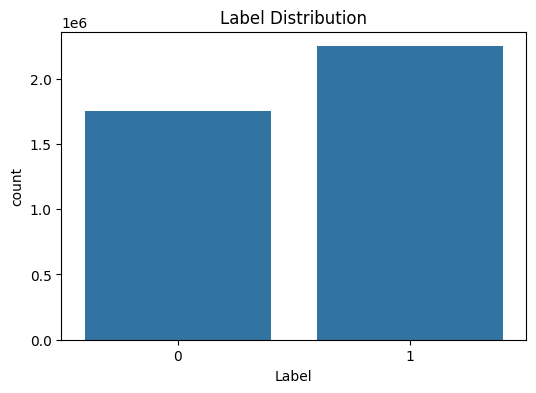


Shape after Incremental PCA: (4000000, 50)
Train: (2800000, 50, 1), Val: (600000, 50, 1), Test: (600000, 50, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 48, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 24, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 24, 32)    │          0 │ conv1d_2[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 22, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 22, 64)    │      6,208 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 11, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_1 │ (None, 11, 64)    │          0 │ conv1d_3[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 704)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 704)       │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1408)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     90,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,978 (402.26 KB)

 Trainable params: 102,978 (402.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - accuracy: 0.9560 - loss: 0.1380 - val_accuracy: 0.9801 - val_loss: 0.0699
Epoch 2/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9787 - loss: 0.0745 - val_accuracy: 0.9808 - val_loss: 0.0629
Epoch 3/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - accuracy: 0.9804 - loss: 0.0673 - val_accuracy: 0.9821 - val_loss: 0.0589
Epoch 4/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.9814 - loss: 0.0633 - val_accuracy: 0.9831 - val_loss: 0.0559
Epoch 5/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - accuracy: 0.9820 - loss: 0.0604 - val_accuracy: 0.9828 - val_loss: 0.0554
Epoch 6/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9825 - loss: 0.0580 - val_accuracy: 0.9835 - val_loss: 0.0530
Epoch 7/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.9827 - loss: 0.0566 - val_accuracy: 0.9839 - val_loss: 0.0519
Epoch 8/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 

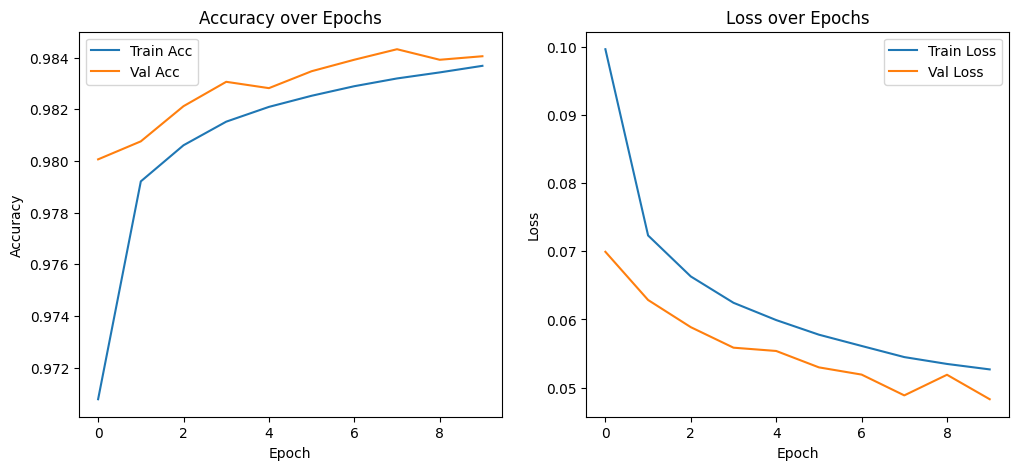

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step


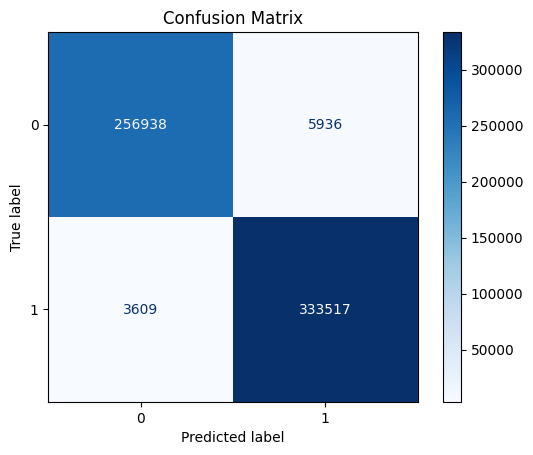


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98    262874
     Class 1       0.98      0.99      0.99    337126

    accuracy                           0.98    600000
   macro avg       0.98      0.98      0.98    600000
weighted avg       0.98      0.98      0.98    600000



In [ ]:
# %% ------------------ Imports ------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# %% ------------------ 1. Load Parquet in chunks ------------------
file_path = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"

# Sample to save RAM
df = pd.read_parquet(file_path).sample(4000000, random_state=42)

print("First 10 rows:")
print(df.head(10))

# %% ------------------ 2. Explore Attack and Label columns ------------------
print("\nUnique values in 'Attack' column and counts:")
print(df['Attack'].value_counts())

print("\nUnique values in 'Label' column and counts:")
print(df['Label'].value_counts())

# Optional: Plot label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=df)
plt.title("Label Distribution")
plt.show()

# %% ------------------ 3. Preprocessing ------------------
X = df.drop(columns=['Attack', 'Label'])
y = df['Label'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Incremental PCA
n_components = 50
ipca = IncrementalPCA(n_components=n_components, batch_size=5000)
X_reduced = ipca.fit_transform(X_scaled)
print("\nShape after Incremental PCA:", X_reduced.shape)

# Reshape for CNN
X_reduced = np.expand_dims(X_reduced, axis=2)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# %% ------------------ 4. CNN Model ------------------
def create_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Path 1
    x1 = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(64, kernel_size=3, activation='relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)

    # Path 2
    x2 = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x2 = AveragePooling1D(pool_size=2)(x2)
    x2 = Conv1D(64, kernel_size=3, activation='relu')(x2)
    x2 = AveragePooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)

    merged = Concatenate()([x1, x2])
    dense = Dense(64, activation='relu')(merged)
    drop = Dropout(0.3)(dense)
    output = Dense(num_classes, activation='softmax')(drop)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# %% ------------------ 5. Train and Evaluate ------------------
num_classes = len(np.unique(y))
input_shape = (X_reduced.shape[1], X_reduced.shape[2])

model = create_model(input_shape, num_classes)
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Test Accuracy: {test_acc:.4f}")

# %% ------------------ 6. Plot Training History ------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# %% ------------------ 7. Confusion Matrix ------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# %% ------------------ 8. Classification Report ------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


First 10 rows:
         Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
2050539         6          44399                  5                       2   
2338650         6         633847                  7                       5   
3059126         6          43029                  5                       3   
1159980         6          60250                  4                       5   
1364066         6          41999                  3                       2   
3368370         6            105                  2                       0   
287322         17        3136805                 16                       0   
419392          6            679                  2                       0   
3380199         6         670722                  3                       4   
4224287         6         696236                  5                       5   

         Fwd Packets Length Total  Bwd Packets Length Total  \
2050539                     363.0                   

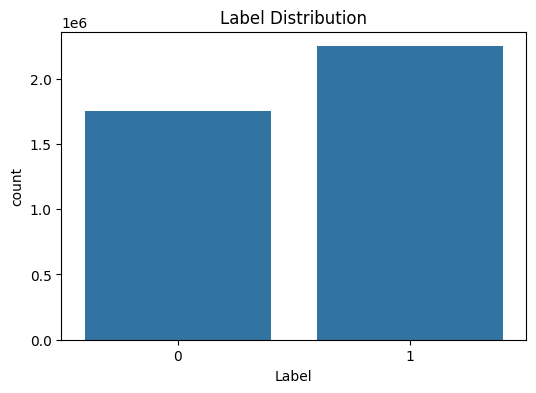


Shape after Incremental PCA: (4000000, 50)
Train: (2800000, 50, 1), Val: (600000, 50, 1), Test: (600000, 50, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 48, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 24, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 24, 32)    │          0 │ conv1d_2[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 22, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 22, 64)    │      6,208 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 11, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_1 │ (None, 11, 64)    │          0 │ conv1d_3[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 704)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 704)       │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1408)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     90,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,978 (402.26 KB)

 Trainable params: 102,978 (402.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.9597 - loss: 0.1289 - val_accuracy: 0.9793 - val_loss: 0.0729
Epoch 2/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.9794 - loss: 0.0734 - val_accuracy: 0.9809 - val_loss: 0.0684
Epoch 3/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.9811 - loss: 0.0666 - val_accuracy: 0.9823 - val_loss: 0.0588
Epoch 4/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.9817 - loss: 0.0627 - val_accuracy: 0.9829 - val_loss: 0.0552
Epoch 5/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.9824 - loss: 0.0585 - val_accuracy: 0.9829 - val_loss: 0.0536
Epoch 6/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.9826 - loss: 0.0574 - val_accuracy: 0.9837 - val_loss: 0.0504
Epoch 7/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9830 - loss: 0.0559 - val_accuracy: 0.9838 - val_loss: 0.0512
Epoch 8/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 

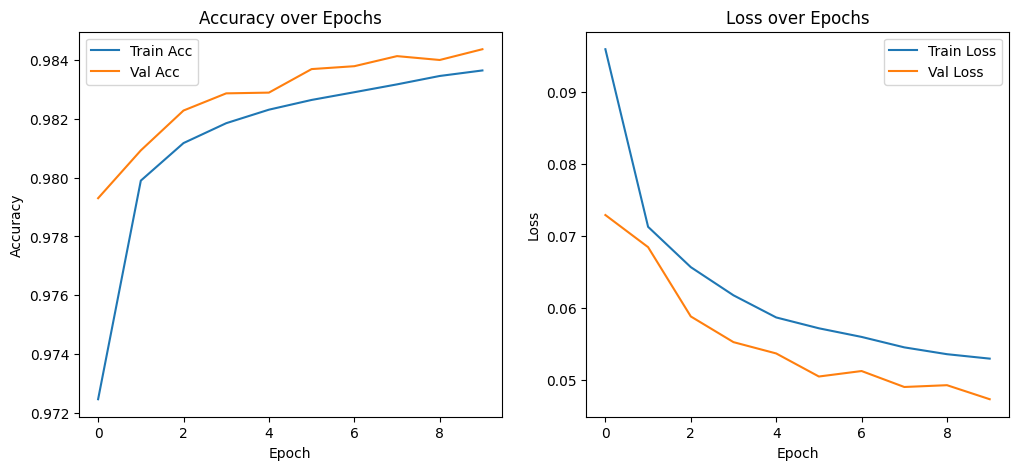

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step


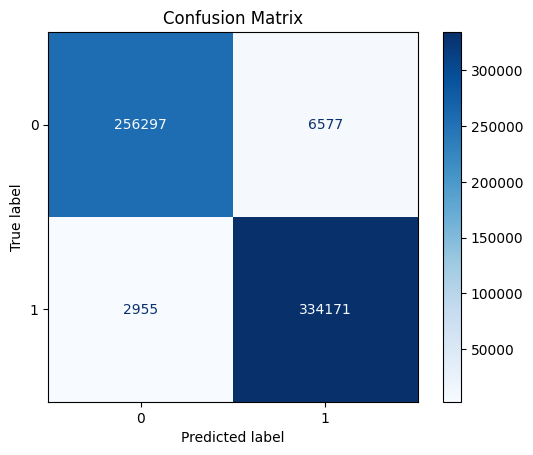


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98    262874
     Class 1       0.98      0.99      0.99    337126

    accuracy                           0.98    600000
   macro avg       0.98      0.98      0.98    600000
weighted avg       0.98      0.98      0.98    600000



In [ ]:
# %% ------------------ Imports ------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# %% ------------------ 1. Load Parquet in chunks ------------------
file_path = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"

# Sample to save RAM
df = pd.read_parquet(file_path).sample(4000000, random_state=42)

print("First 10 rows:")
print(df.head(10))

# %% ------------------ 2. Explore Attack and Label columns ------------------
print("\nUnique values in 'Attack' column and counts:")
print(df['Attack'].value_counts())

print("\nUnique values in 'Label' column and counts:")
print(df['Label'].value_counts())

# Optional: Plot label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=df)
plt.title("Label Distribution")
plt.show()

# %% ------------------ 3. Preprocessing ------------------
X = df.drop(columns=['Attack', 'Label'])
y = df['Label'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Incremental PCA
n_components = 50
ipca = IncrementalPCA(n_components=n_components, batch_size=5000)
X_reduced = ipca.fit_transform(X_scaled)
print("\nShape after Incremental PCA:", X_reduced.shape)

# Reshape for CNN
X_reduced = np.expand_dims(X_reduced, axis=2)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# %% ------------------ 4. CNN Model ------------------
def create_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Path 1
    x1 = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(64, kernel_size=3, activation='relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)

    # Path 2
    x2 = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x2 = AveragePooling1D(pool_size=2)(x2)
    x2 = Conv1D(64, kernel_size=3, activation='relu')(x2)
    x2 = AveragePooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)

    merged = Concatenate()([x1, x2])
    dense = Dense(64, activation='relu')(merged)
    drop = Dropout(0.3)(dense)
    output = Dense(num_classes, activation='softmax')(drop)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# %% ------------------ 5. Train and Evaluate ------------------
num_classes = len(np.unique(y))
input_shape = (X_reduced.shape[1], X_reduced.shape[2])

model = create_model(input_shape, num_classes)
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# %% ------------------ 6. Plot Training History ------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# %% ------------------ 7. Confusion Matrix ------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# %% ------------------ 8. Classification Report ------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


Loaded sample shape: (800000, 79)
Ransomware samples: 768
Training samples (non-ransomware): 799232
Train: (559462, 40, 1), Val: (119885, 40, 1), Test: (119885, 40, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 38, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 38, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 19, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 19, 32)    │          0 │ conv1d_2[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 17, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 17, 64)    │      6,208 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 8, 64)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_1 │ (None, 8, 64)     │          0 │ conv1d_3[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     65,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │        585 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,857 (308.04 KB)

 Trainable params: 78,857 (308.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.7886 - loss: 0.6363 - val_accuracy: 0.8356 - val_loss: 0.4638
Epoch 2/5
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8366 - loss: 0.4764 - val_accuracy: 0.8463 - val_loss: 0.4332
Epoch 3/5
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8446 - loss: 0.4474 - val_accuracy: 0.8491 - val_loss: 0.4214
Epoch 4/5
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8463 - loss: 0.4357 - val_accuracy: 0.8506 - val_loss: 0.4119
Epoch 5/5
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8481 - loss: 0.4259 - val_accuracy: 0.8511 - val_loss: 0.4052

✅ Normal Test Accuracy (non-ransomware): 0.8518
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  

🔍 Predictions on ransomware samples:
Benign: 750
backdoor: 1
injection: 5
xss: 12
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


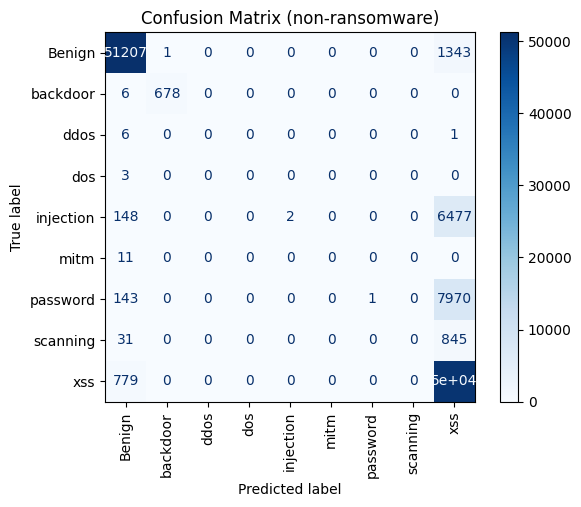


Classification Report (non-ransomware):
              precision    recall  f1-score   support

      Benign       0.98      0.97      0.98     52551
    backdoor       1.00      0.99      0.99       684
        ddos       0.00      0.00      0.00         7
         dos       0.00      0.00      0.00         3
   injection       1.00      0.00      0.00      6627
        mitm       0.00      0.00      0.00        11
    password       1.00      0.00      0.00      8114
    scanning       0.00      0.00      0.00       876
         xss       0.75      0.98      0.85     51012

    accuracy                           0.85    119885
   macro avg       0.53      0.33      0.31    119885
weighted avg       0.88      0.85      0.80    119885



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# %% ------------------ Imports ------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# %% ------------------ Config ------------------
file_path = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"
SAMPLE_SIZE = 800_000
N_COMPONENTS = 40
BATCH_SIZE = 10_000

# %% ------------------ 1. Load Data ------------------
df = pd.read_parquet(file_path).sample(SAMPLE_SIZE, random_state=42)
print(f"Loaded sample shape: {df.shape}")

# %% ------------------ 2. Split ransomware vs rest ------------------
df_ransomware = df[df['Attack'] == "ransomware"].copy()
df_rest = df[df['Attack'] != "ransomware"].copy()

print(f"Ransomware samples: {len(df_ransomware)}")
print(f"Training samples (non-ransomware): {len(df_rest)}")

# %% ------------------ 3. Preprocessing ------------------
X = df_rest.drop(columns=['Attack', 'Label'])
y = df_rest['Label'].values   # Binary labels: 0/1

# Free original df_rest to save RAM
del df_rest

# Standardize + PCA incrementally
scaler = StandardScaler()
ipca = IncrementalPCA(n_components=N_COMPONENTS, batch_size=BATCH_SIZE)

# Fit scaler incrementally
for i in range(0, len(X), BATCH_SIZE):
    batch = X.iloc[i:i+BATCH_SIZE]
    scaler.partial_fit(batch)

# Fit PCA incrementally
for i in range(0, len(X), BATCH_SIZE):
    batch = scaler.transform(X.iloc[i:i+BATCH_SIZE])
    ipca.partial_fit(batch)

# Transform full dataset in batches
X_reduced_list = []
for i in range(0, len(X), BATCH_SIZE):
    batch = scaler.transform(X.iloc[i:i+BATCH_SIZE])
    X_reduced_list.append(ipca.transform(batch))

X_reduced = np.vstack(X_reduced_list)
del X, X_reduced_list

# Reshape for CNN
X_reduced = np.expand_dims(X_reduced, axis=2)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# %% ------------------ 4. Prepare ransomware set ------------------
if len(df_ransomware) > 0:
    X_ransom = df_ransomware.drop(columns=['Attack', 'Label'])
    X_ransom = scaler.transform(X_ransom)
    X_ransom = ipca.transform(X_ransom)
    X_ransom = np.expand_dims(X_ransom, axis=2)
    y_ransom = np.full(len(X_ransom), -1)  # Placeholder
else:
    X_ransom, y_ransom = np.array([]), np.array([])

# %% ------------------ 5. CNN Model ------------------
def create_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Path 1
    x1 = Conv1D(32, 3, activation='relu')(input_layer)
    x1 = MaxPooling1D(2)(x1)
    x1 = Conv1D(64, 3, activation='relu')(x1)
    x1 = MaxPooling1D(2)(x1)
    x1 = Flatten()(x1)

    # Path 2
    x2 = Conv1D(32, 3, activation='relu')(input_layer)
    x2 = AveragePooling1D(2)(x2)
    x2 = Conv1D(64, 3, activation='relu')(x2)
    x2 = AveragePooling1D(2)(x2)
    x2 = Flatten()(x2)

    merged = Concatenate()([x1, x2])
    dense = Dense(64, activation='relu')(merged)
    drop = Dropout(0.3)(dense)
    output = Dense(1, activation='sigmoid')(drop)  # Binary classification

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# %% ------------------ 6. Train ------------------
input_shape = (X_reduced.shape[1], X_reduced.shape[2])
model = create_model(input_shape)
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128,
    verbose=1
)

# %% ------------------ 7. Evaluate ------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

if len(X_ransom) > 0:
    y_ransom_pred = (model.predict(X_ransom, batch_size=256) > 0.5).astype(int)
    unique, counts = np.unique(y_ransom_pred, return_counts=True)
    print("\n🔍 Predictions on ransomware samples:")
    for u, c in zip(unique, counts):
        print(f"Class {u}: {c}")

# %% ------------------ 8. Confusion Matrix ------------------
y_pred = (model.predict(X_test, batch_size=256) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# %% ------------------ 9. Classification Report ------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0','Class 1']))
